In [9]:
from entsoe import EntsoePandasClient
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from pathlib import Path

In [10]:
api_key = '89386f2b-798b-4675-bd4d-2c5e3fe4b7d3'
client = EntsoePandasClient(api_key=api_key)

In [11]:
start = pd.Timestamp('20180101', tz='Europe/Brussels')
end = pd.Timestamp('20230101', tz='Europe/Brussels')

In [4]:
def get_transmission_data(market_from, market_to, start, end):
    # print(f'Getting data from {market_from} to {market_to}')
    return pd.DataFrame(data=client.query_crossborder_flows(market_from, market_to, start=start, end=end), columns=[market_to])

In [5]:
nlbe = get_transmission_data('NL', 'BE', start, end)
benl = get_transmission_data('BE', 'NL', start, end)

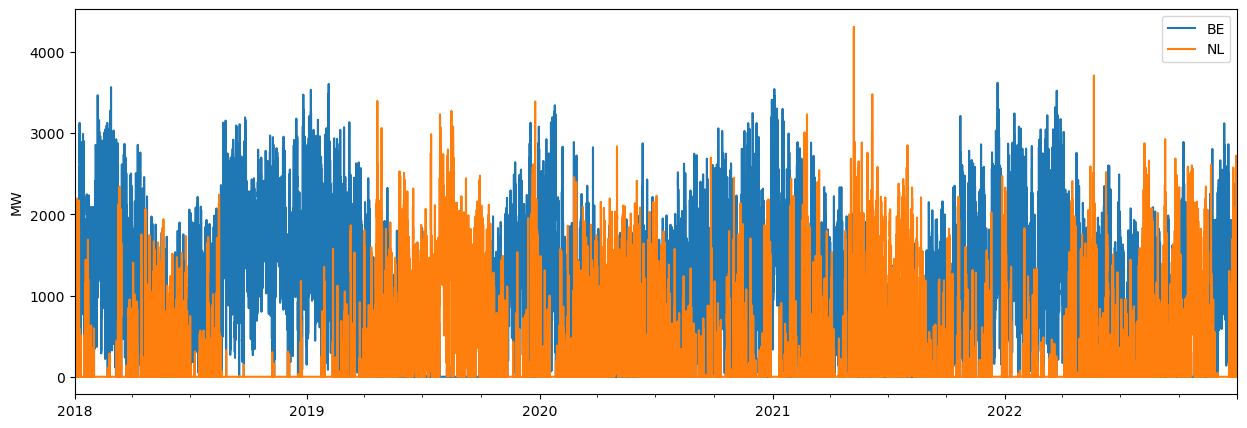

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
nlbe.plot(ax=ax, label='NL -> BE')
benl.plot(ax=ax, label='BE -> NL')
ax.set_ylabel('MW')
ax.legend()

In [51]:
markets = ['NL', 'DE_LU', 'NO', 'DK', 'BE', 'FR', 'SE']

In [62]:
cb_data = {}
for market_from in tqdm(markets):
    cb_data[market_from] = {}
    for market_to in markets:
        if market_from == market_to:
            continue
        try:
            cb_data[market_from][market_to] = get_transmission_data(market_from, market_to, start, end)
        
        except:
            pass

100%|██████████| 7/7 [08:14<00:00, 70.67s/it]


In [67]:
cb_data.keys()

dict_keys(['NL', 'DE_LU', 'NO', 'DK', 'BE', 'FR', 'SE'])

In [80]:
cb_data['NL']['NO']

,NO
2018-01-01 00:00:00+01:00,26.0
2018-01-01 01:00:00+01:00,0.0
2018-01-01 02:00:00+01:00,169.0
2018-01-01 03:00:00+01:00,629.0
2018-01-01 04:00:00+01:00,247.0
...,...
2022-12-31 19:00:00+01:00,620.0
2022-12-31 20:00:00+01:00,649.0
2022-12-31 21:00:00+01:00,649.0
2022-12-31 22:00:00+01:00,649.0


In [23]:
cb_data = cb_dfs

In [24]:
cb_dfs = { market_from: pd.DataFrame(index=pd.date_range(start=start, end=end, freq='15T'), columns=cb_data[market_from].keys()) for market_from in cb_data.keys() }

for market_from in cb_data.keys():
    df = pd.DataFrame(index=pd.date_range(start=start, end=end, freq='H'), columns=cb_data[market_from].keys())
    for market_to in cb_data[market_from].keys():
        newvals = cb_data[market_from][market_to].resample('1H').mean()
        df.loc[df.index.isin(newvals.index), market_to] = newvals.values.flatten()
    cb_dfs[market_from] = df.copy()

#     market_from: pd.concat([
#         cb_data[market_from][market_to] for market_to in cb_data[market_from].keys()
#     ]) for market_from in cb_data.keys()
# }

In [25]:
cb_data['DE_LU']['NL']

KeyError: 'DE_LU'

In [28]:
cb_dfs['NL']

,DE_LU,NO,DK,BE
2018-01-01 00:00:00+01:00,NaN,26.0,NaN,736.0
2018-01-01 01:00:00+01:00,NaN,0.0,NaN,1226.0
2018-01-01 02:00:00+01:00,NaN,169.0,NaN,1264.0
2018-01-01 03:00:00+01:00,NaN,629.0,NaN,1373.0
2018-01-01 04:00:00+01:00,NaN,247.0,NaN,1678.0
...,...,...,...,...
2022-12-31 20:00:00+01:00,675.0,649.0,0.0,0.0
2022-12-31 21:00:00+01:00,719.75,649.0,431.0,0.0
2022-12-31 22:00:00+01:00,268.25,649.0,698.0,0.0
2022-12-31 23:00:00+01:00,870.75,649.0,689.0,0.0


In [102]:
cb_dfs['NL'].dropna()

,DE_LU,NO,DK,BE
2019-09-07 02:00:00+02:00,1863.0,0.0,0.0,0.0
2019-09-07 03:00:00+02:00,1747.0,0.0,0.0,0.0
2019-09-07 04:00:00+02:00,1994.0,0.0,0.0,0.0
2019-09-07 05:00:00+02:00,2061.0,0.0,0.0,0.0
2019-09-07 06:00:00+02:00,2145.0,0.0,0.0,0.0
...,...,...,...,...
2022-12-31 19:00:00+01:00,750.25,620.0,0.0,0.0
2022-12-31 20:00:00+01:00,675.0,649.0,0.0,0.0
2022-12-31 21:00:00+01:00,719.75,649.0,431.0,0.0
2022-12-31 22:00:00+01:00,268.25,649.0,698.0,0.0


<Axes: >

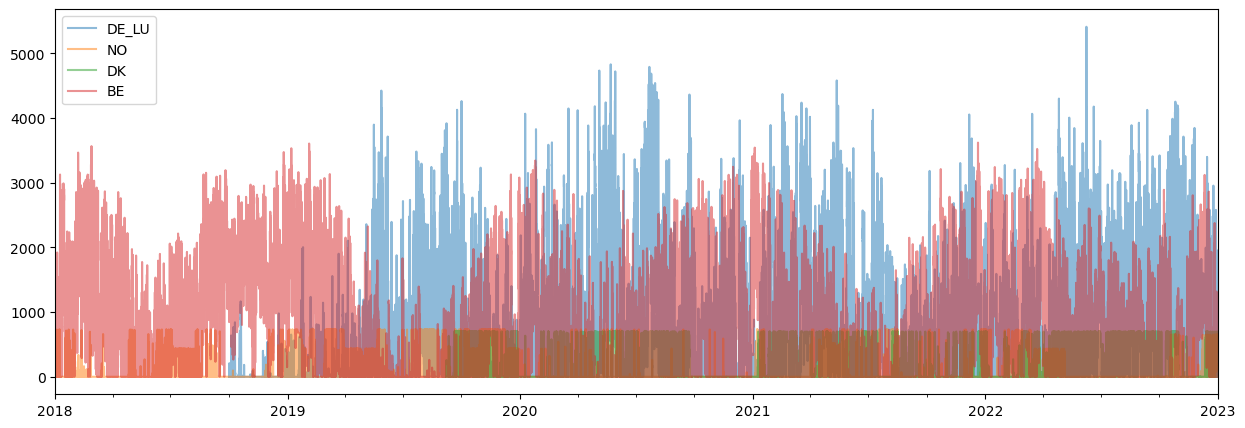

In [104]:
cb_dfs['NL'].plot(figsize=(15, 5), alpha=0.5)

In [32]:
with pd.HDFStore('data.h5') as store:
    for market, data in cb_data.items():
        store.put('crossborder/{}'.format(market), data)

,0
2019-01-01 00:00:00+01:00,0.0
2019-01-01 01:00:00+01:00,0.0
2019-01-01 02:00:00+01:00,0.0
2019-01-01 03:00:00+01:00,0.0
2019-01-01 04:00:00+01:00,0.0
...,...
2019-12-31 19:00:00+01:00,470.0
2019-12-31 20:00:00+01:00,462.0
2019-12-31 21:00:00+01:00,671.0
2019-12-31 22:00:00+01:00,750.0


In [12]:
datapath = Path().resolve().parent.parent.parent / 'data' / 'market data'
datapath

WindowsPath('D:/Users/Heijden/Documents/PhD work/Current work/EGU23/data/market data')

In [16]:
cb_dfs['DE'] = cb_dfs['DE_LU'].copy()

cb_dfs = {k: cb_dfs[k] for k in cb_dfs.keys() if k != 'DE_LU'}

In [13]:
with open(datapath / 'edge_DAM_data.pkl', 'rb') as f:
    cb_dfs = pickle.load(f)

In [30]:
for k in cb_dfs.keys():
    cols = []
    for col in cb_dfs[k].columns:
        if col == 'DE_LU':
            cols.append('DE')
        else:
            cols.append(col)
    cb_dfs[k].columns = cols

In [29]:
cb_dfs['NL']

,DE_LU,NO,DK,BE
2018-01-01 00:00:00+01:00,NaN,26.0,NaN,736.0
2018-01-01 01:00:00+01:00,NaN,0.0,NaN,1226.0
2018-01-01 02:00:00+01:00,NaN,169.0,NaN,1264.0
2018-01-01 03:00:00+01:00,NaN,629.0,NaN,1373.0
2018-01-01 04:00:00+01:00,NaN,247.0,NaN,1678.0
...,...,...,...,...
2022-12-31 20:00:00+01:00,675.0,649.0,0.0,0.0
2022-12-31 21:00:00+01:00,719.75,649.0,431.0,0.0
2022-12-31 22:00:00+01:00,268.25,649.0,698.0,0.0
2022-12-31 23:00:00+01:00,870.75,649.0,689.0,0.0


In [109]:
with open(datapath / 'edge_DAM_data.pkl', 'wb') as f:
    pickle.dump(cb_dfs, f)